In [1]:
import os
import datetime as dt

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
new_df = pd.read_csv("data.csv")
new_df.head()

,Timestamp,Low,Volume_(BTC),Volume_(Currency),Weighted_Price,High,Close,Open
0,2017-01-01 00:00:00,964.60,102.484806,99027.385808,57003.105500,966.99,966.60,966.34
1,2017-01-01 01:00:00,962.54,149.025554,143716.718251,57850.650345,966.60,963.87,966.60
2,2017-01-01 02:00:00,961.99,94.267396,90901.736168,57845.805546,965.75,963.97,964.35
3,2017-01-01 03:00:00,960.53,77.619667,74736.649237,57834.205077,964.71,962.83,963.97
4,2017-01-01 04:00:00,960.60,46.810220,45054.655498,57772.256943,963.64,963.46,960.61


In [3]:
new_df.shape

(28969, 8)

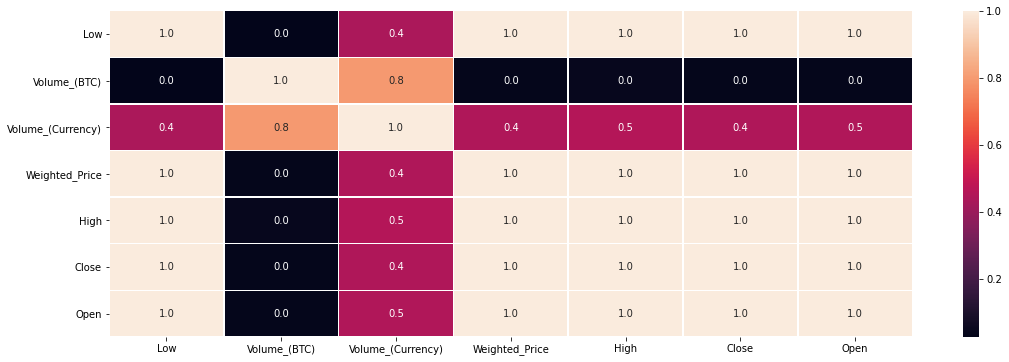

In [4]:
f,ax = plt.subplots(figsize=(18, 6))
sns.heatmap(new_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [5]:
new_df.drop(['High', 'Low', 'Weighted_Price'], inplace=True, axis=1)
new_df.columns = [name.replace('_', '') for name in list(new_df.columns)]
new_df.columns = [name.replace('(', '') for name in list(new_df.columns)]
new_df.columns = [name.replace(')', '') for name in list(new_df.columns)]
new_df.head()

,Timestamp,VolumeBTC,VolumeCurrency,Close,Open
0,2017-01-01 00:00:00,102.484806,99027.385808,966.60,966.34
1,2017-01-01 01:00:00,149.025554,143716.718251,963.87,966.60
2,2017-01-01 02:00:00,94.267396,90901.736168,963.97,964.35
3,2017-01-01 03:00:00,77.619667,74736.649237,962.83,963.97
4,2017-01-01 04:00:00,46.810220,45054.655498,963.46,960.61


In [6]:
new_df.shape

(28969, 5)

In [7]:
# Data Loader Parameters
BATCH_SIZE = 32
BUFFER_SIZE = 10000
# TRAIN_SPLIT = int(len(new_df) * 0.8)
TRAIN_SPLIT = 28921
# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 20
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [8]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        # this create range of 24 from i to i + 24
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

Getting values from column we want to predict

In [9]:
values_data = new_df['Close']
values_data.index = new_df['Timestamp']
values_data.head()

Timestamp
2017-01-01 00:00:00    966.60
2017-01-01 01:00:00    963.87
2017-01-01 02:00:00    963.97
2017-01-01 03:00:00    962.83
2017-01-01 04:00:00    963.46
Name: Close, dtype: float64

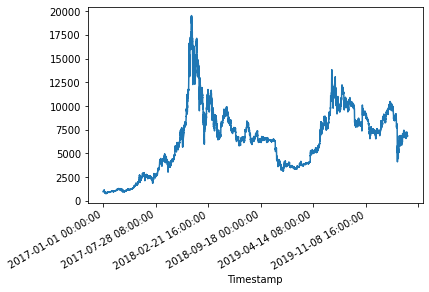

In [10]:
values_data.plot(subplots=True)
plt.show()
values_data = values_data.values

The mean and standard deviation should only be computed using the training data.

In [11]:
values_mean = values_data[:int(TRAIN_SPLIT)].mean()
values_std = values_data[:int(TRAIN_SPLIT)].std()

Normalize Training data

In [12]:
uni_data = (values_data - values_mean) / values_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 24 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [13]:
univariate_past_history = 24
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)

x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [14]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(28969,)
[-1.61498621 -1.61579224 -1.61576271 -1.61609929 -1.61591329]

Out
(28897, 24, 1)
0.9975145845559046


Revisamos shape de X y de Y

In [15]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (24, 1)
[[-1.61498621]
 [-1.61579224]
 [-1.61576271]
 [-1.61609929]
 [-1.61591329]
 [-1.61575385]
 [-1.61552946]
 [-1.61547042]
 [-1.61546451]
 [-1.61528146]
 [-1.61280727]
 [-1.61252974]
 [-1.61324424]
 [-1.6127748 ]
 [-1.61225516]
 [-1.61200124]
 [-1.6071946 ]
 [-1.60783824]
 [-1.60624094]
 [-1.60600179]
 [-1.60513967]
 [-1.60424211]
 [-1.60438678]
 [-1.60578921]]

 Target temperature to predict. Shape: ()
-1.6058069284313878


In [16]:
def create_time_steps(length):
    return list(range(-length, 0))

In [17]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

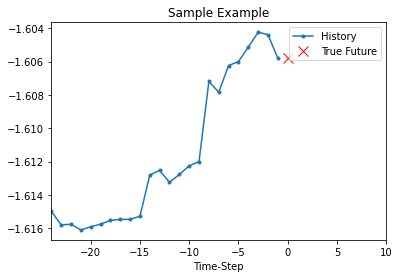

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

*Baseline*<br>
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 24 observations.

In [19]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

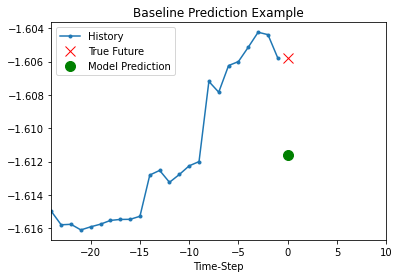

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

*Recurrent neural network*<br>
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the RNN tutorial. In this tutorial, you will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.

In [21]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
x_train_uni.shape

(28897, 24, 1)

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(24, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

Let's make a sample prediction, to check the output of the model.

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(24, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/20
200/200 [==============================] - 2s 12ms/step - loss: 0.2543 - val_loss: 7.3378e-04
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0046 - val_loss: 8.9026e-05
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0021 - val_loss: 9.2427e-05
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0017 - val_loss: 1.2333e-04
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 1.2295e-04


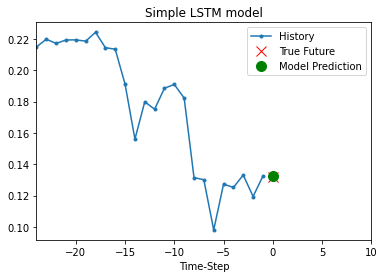

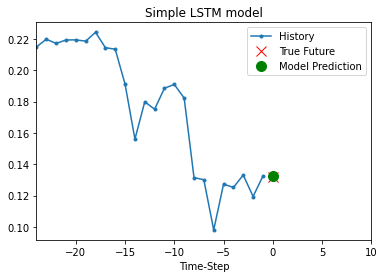

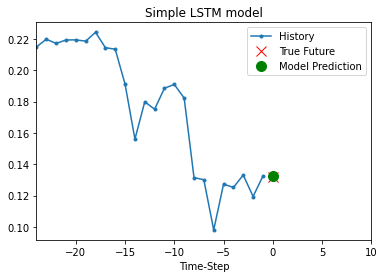

In [26]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

In [27]:
# del simple_lstm_model, val_univariate, train_univariate

<h1>Forecast a multivariate time series</h1>

In [28]:
new_df = pd.read_csv("data.csv")
new_df.head()

,Timestamp,Low,Volume_(BTC),Volume_(Currency),Weighted_Price,High,Close,Open
0,2017-01-01 00:00:00,964.60,102.484806,99027.385808,57003.105500,966.99,966.60,966.34
1,2017-01-01 01:00:00,962.54,149.025554,143716.718251,57850.650345,966.60,963.87,966.60
2,2017-01-01 02:00:00,961.99,94.267396,90901.736168,57845.805546,965.75,963.97,964.35
3,2017-01-01 03:00:00,960.53,77.619667,74736.649237,57834.205077,964.71,962.83,963.97
4,2017-01-01 04:00:00,960.60,46.810220,45054.655498,57772.256943,963.64,963.46,960.61


In [29]:
features_considered = ['Open', 'Weighted_Price', 'Close']

In [30]:
features = new_df[features_considered]
features.index = new_df['Timestamp']
features.head()

,Open,Weighted_Price,Close
Timestamp,,,
2017-01-01 00:00:00,966.34,57003.105500,966.60
2017-01-01 01:00:00,966.60,57850.650345,963.87
2017-01-01 02:00:00,964.35,57845.805546,963.97
2017-01-01 03:00:00,963.97,57834.205077,962.83
2017-01-01 04:00:00,960.61,57772.256943,963.46


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9551736be0>,
      dtype=object)

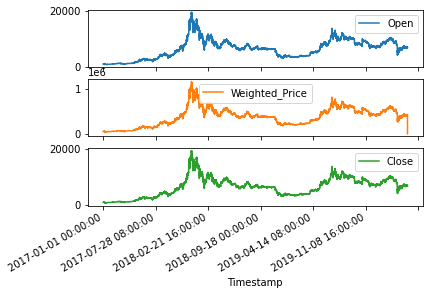

In [31]:
features.plot(subplots=True)

In [32]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [33]:
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,Open,Weighted_Price,Close
Timestamp,,,
2017-01-01 00:00:00,-1.614863,-1.619847,-1.614986
2017-01-01 01:00:00,-1.614787,-1.615676,-1.615792
2017-01-01 02:00:00,-1.615451,-1.615700,-1.615763
2017-01-01 03:00:00,-1.615563,-1.615757,-1.616099
2017-01-01 04:00:00,-1.616555,-1.616062,-1.615913


In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [35]:
past_history = 24
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [36]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(28897, 24, 3)
Single window of past history : (24, 3)
(24, 3)


In [37]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [38]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(24, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(units=24, activation='relu'))
single_step_model.add(tf.keras.layers.Dropout(0.4))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mse')

In [39]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(24, 1)


In [40]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 20
Epoch 1/20
200/200 [==============================] - 3s 14ms/step - loss: 0.3293 - val_loss: 0.1665
Epoch 2/20
200/200 [==============================] - 2s 11ms/step - loss: 0.0728 - val_loss: 0.1670
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0652 - val_loss: 0.1699
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 0.0477 - val_loss: 0.1690


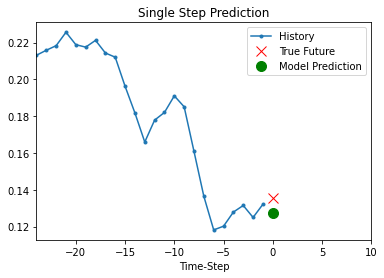

In [41]:
for x, y in val_data_single.take(1):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]],0,
                   'Single Step Prediction')
    plot.show()

In [60]:
past_history = 24
future_target = 1
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [61]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [62]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

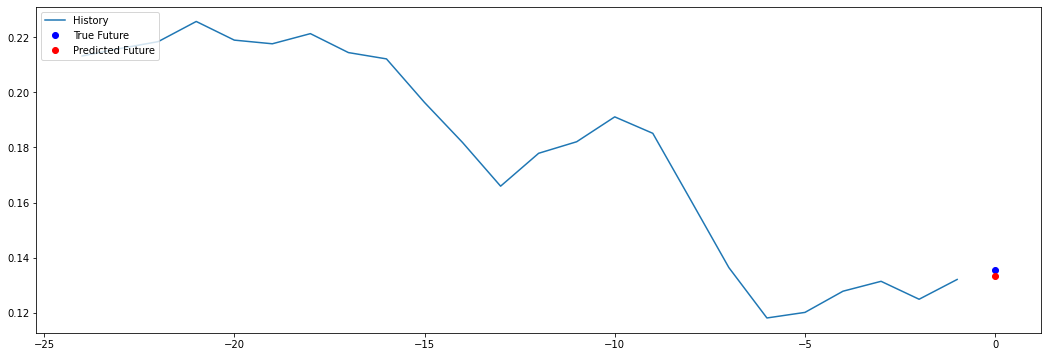

In [80]:
for x, y in val_data_multi.take(1):
    multi_step_plot(x[0], y[0], single_step_model.predict(x)[-1])